In [1]:
import numpy as np
import processingIO as pio
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
from dataUtilities import filterData
from forceClass import Forces, ForceCoefficients

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

In [2]:
def power_law(xData, a, b, c):
        return a + (b * xData) + (c * xData**2)

def fit_data(xData, yData):

    popt, pcov = curve_fit(power_law, xData, yData, p0=[0.5, 0.5, 0.5])

    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)

    r_squared = 1 - (ss_res/ss_total)

    return popt, r_squared

In [3]:
data_location = r'/media/mco143/2TB/Archived_OpenFOAM_Simulations/Anderson_validation/Anderson_st_maxCo1'

force_paths = pio.get_files(data_location, 'force.dat')
force_paths.sort()
coefficients_paths = pio.get_files(data_location, 'coefficient.dat')
coefficients_paths.sort()
solver_paths = pio.get_files(data_location, 'log.solver')
solver_paths.sort()

tmp = []

constantDict = {'parentCase':[], 'specificCase':[], 'totalTime':[]}

for solverFile in solver_paths:
    constantDict['parentCase'].append(solverFile.parts[-4])
    constantDict['specificCase'].append(solverFile.parts[-3])
    with open(solverFile, 'r') as f:
        for line in f:
            if 'ExecutionTime' in line:
                tmp.append(line.split()[2])

    constantDict['totalTime'].append(tmp[-1]) 

cycles =  1
total_cycles = 3.0

forces = [Forces(filepath, cycles, total_cycles, True, True) for filepath in force_paths]
coeffs = [ForceCoefficients(filepath, cycles, total_cycles, True, True) for filepath in coefficients_paths]

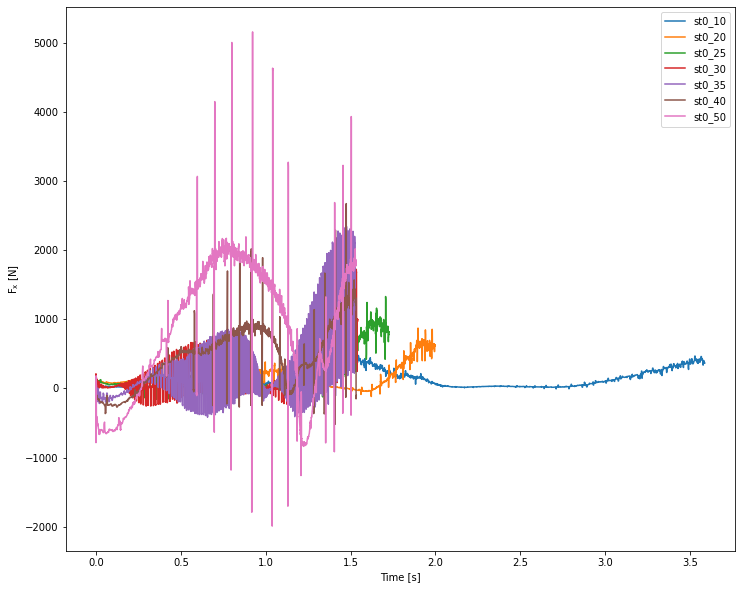

In [7]:
figure_path = r'../figures/'
density = 1025
fudgeFactor = 1.0
U = 1.0
kinvis = 2.5e-5
chord = 1.0

average_fx = []
case = []

fig1, ax1 = plt.subplots(figsize=(12,10))
for force in forces:
    average_fx.append(force.averageFilteredForces['total']['x']/(0.5*density*U**2*chord))
    case.append(force.specific_case)

    ax1.plot(force.filteredForces['time'], force.filteredForces['total']['x'], label=force.specific_case)

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('$\mathrm{F_x}$ [N]')
#ax2 = plt.axes([0, 0, 1, 1])
#ip = InsetPosition(ax1, [0.2,0.4,0.55,0.55])
#ax2.set_axes_locator(ip)
#mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.5')

#ax1.set_ylim([-500, 500])
ax1.legend()

average_fx = np.asarray(average_fx)

fig1.savefig(Path(figure_path).joinpath('raw_anderson_data.png'), facecolor='w')

In [5]:
anderson_data = r'/home/mco143/Documents/Current_OpenFOAM_Simulations/Anderson_validation.xlsx'
andersonDF = pd.read_excel(anderson_data, sheet_name='alpha15')

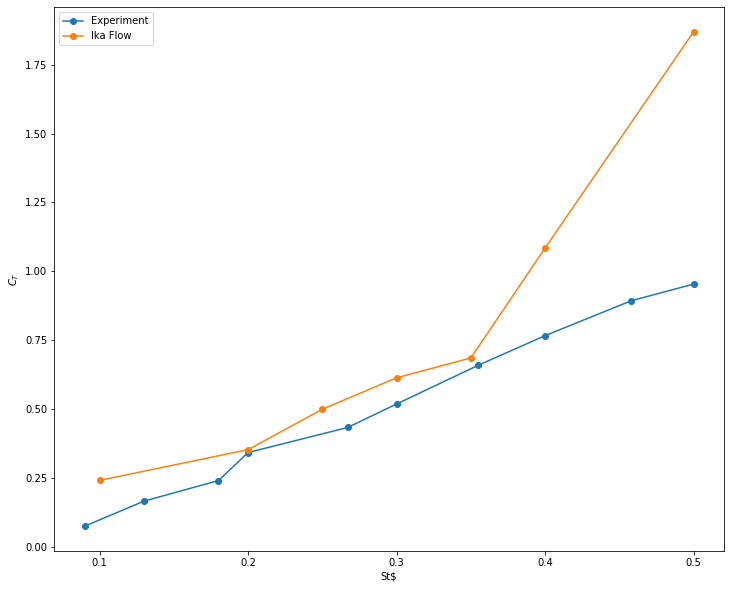

In [9]:
a_st = np.array([0.10, 0.20, 0.25, 0.30, 0.35, 0.40, 0.50])

fig2, ax2 = plt.subplots(figsize=(12,10))
ax2.plot(andersonDF['Strouhal'], andersonDF['Ct'], 'o-', label="Experiment")
ax2.plot(a_st, average_fx, 'o-', label='Ika Flow')

ax2.set_xlabel(r'St$')
ax2.set_ylabel('$C_T$')

ax2.legend()
fig2.savefig(Path(figure_path).joinpath('Anderson_data.png'), facecolor='w')